##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [20]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
orig_df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [22]:
df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [23]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [24]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [25]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.

## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


### Answer -- Task 1:

1. Printing a few rows of the values in the DataFrame `df`:


In [26]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


2. Identifying the input and target variables:

   - Input Variables:
     - Latitude (`X`)
     - Longitude (`Y`)
     - Hour of the day (`Time`)
     - Day of the week (`DayOfWeek`)
     - Area-of-command code (`Area_Command`)
     - Classification code for the crime committed (`NIBRSOffenseCode`)

   - Target Variable:
     - Number of persons involved in the crime (`VictimCount`)

3. Range of values in each column:

   - Latitude (`X`) and Longitude (`Y`): These represent geographical coordinates and may have a wide range of values depending on the area. It's common to scale these values to a smaller range, such as [0, 1] or [-1, 1].
   - Hour of the day (`Time`): This likely ranges from 0 to 23, representing the 24-hour clock.
   - Day of the week (`DayOfWeek`): This ranges from 0 to 6, representing the days of the week (0 for Monday, 1 for Tuesday, and so on).
   - Area-of-command code (`Area_Command`) and Classification code for the crime (`NIBRSOffenseCode`): These are categorical variables that have been encoded using integer labels. You may not need to further scale or normalize them.
   - Number of persons involved in the crime (`VictimCount`): This represents a count and may have values ranging from 0 to a higher number.

   Depending on the machine learning algorithm we plan to use, scaling numerical features like latitude, longitude, and time to a common range (e.g., [0, 1]) can be beneficial for training stability.


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [27]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define batch size
batch_size = 64

# Define custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx, :-1].values  # Input features
        y = self.dataframe.iloc[idx, -1]          # Target variable
        return x, y

# Create DataLoader objects for training and testing
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over one dataset (e.g., train_loader)
for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break  # Print the shape of the first batch only


Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


Above code does the following:

- Splits the dataset into training and testing sets.
- Defines a custom `Dataset` class to load the data.
- Creates `DataLoader` objects for both training and testing.
- Iterates over the training DataLoader to print the shape of the input and target data in the first batch.


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [28]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Define hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh()]

# Define a custom Dataset class (assuming df is defined as before)
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx, :-1].values  # Input features
        y = self.dataframe.iloc[idx, -1]          # Target variable
        return x, y

# Create DataLoader objects for training and testing (reusing from Task 2)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_loader = DataLoader(CustomDataset(train_df), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_df), batch_size=64, shuffle=False)

best_mse = float('inf')
best_params = {}
best_model = None

# Define input_size based on the number of features (excluding the target variable)
input_size = len(train_df.columns) - 1

for lr in learning_rates:
    for size in hidden_sizes:
        for activation in activation_functions:
            class CustomModel(nn.Module):
                def __init__(self, input_dim, hidden_size, activation):
                    super(CustomModel, self).__init__()
                    self.layer1 = nn.Linear(input_dim, hidden_size)
                    self.layer2 = nn.Linear(hidden_size, hidden_size)
                    self.output_layer = nn.Linear(hidden_size, 1)
                    self.activation = activation

                def forward(self, x):
                    x = self.activation(self.layer1(x))
                    x = self.activation(self.layer2(x))
                    return self.output_layer(x)

            model = CustomModel(input_size, size, activation)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            print(f"\nTraining model with LR={lr}, Hidden Size={size}, Activation={type(activation).__name__}:")
            mse = train_and_evaluate(model, train_loader, test_loader, optimizer, nn.MSELoss(), epochs=10)

            # Keep track of best parameters and model
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    'learning_rate': lr,
                    'hidden_size': size,
                    'activation': type(activation).__name__
                }
                best_model = model

print("\nBest Model Parameters:", best_params)

# Evaluate the best model on the test data
best_model.eval()
with torch.no_grad():
    test_losses = []
    predictions = []
    targets = []
    for data, labels in test_loader:
        outputs = best_model(data.float())
        test_loss = nn.MSELoss()(outputs, labels.float())
        test_losses.append(test_loss.item())
        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Calculate and print the mean squared error (MSE)
test_mse = np.mean(test_losses)
print(f"Test MSE: {test_mse}")


Training model with LR=0.001, Hidden Size=32, Activation=ReLU:
Epoch 1/10, Test MSE: 1.0991690158843994
Epoch 2/10, Test MSE: 3.0734126567840576
Epoch 3/10, Test MSE: 1.2181638479232788
Epoch 4/10, Test MSE: 1.6543357372283936

C:\Users\ashle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ashle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ashle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Py


Epoch 5/10, Test MSE: 1.8016023635864258
Epoch 6/10, Test MSE: 1.0863869190216064
Epoch 7/10, Test MSE: 1.1432808637619019


Epoch 8/10, Test MSE: 1.1140891313552856
Epoch 9/10, Test MSE: 1.035735845565796
Epoch 10/10, Test MSE: 1.1323368549346924

Training model with LR=0.001, Hidden Size=32, Activation=LeakyReLU:
Epoch 1/10, Test MSE: 7.7429656982421875
Epoch 2/10, Test MSE: 1.0070688724517822
Epoch 3/10, Test MSE: 3.177388906478882
Epoch 4/10, Test MSE: 3.647317886352539
Epoch 5/10, Test MSE: 1.837404727935791
Epoch 6/10, Test MSE: 1.001004934310913
Epoch 7/10, Test MSE: 1.179362416267395
Epoch 8/10, Test MSE: 1.3317694664001465
Epoch 9/10, Test MSE: 1.139596939086914
Epoch 10/10, Test MSE: 0.9840992093086243

Training model with LR=0.001, Hidden Size=32, Activation=Sigmoid:
Epoch 1/10, Test MSE: 1.0834678411483765
Epoch 2/10, Test MSE: 1.0081723928451538
Epoch 3/10, Test MSE: 0.9634454250335693
Epoch 4/10, Test MSE: 0.9401419758796692
Epoch 5/10, Test MSE: 0.9336702823638916
Epoch 6/10, Test MSE: 0.9356168508529663
Epoch 7/10, Test MSE: 0.9383547902107239
Epoch 8/10, Test MSE: 0.9406986832618713
Epoch 9/

### Loss Function
For this regression task, the proper loss function is Mean Squared Error (MSE). MSE measures the average squared difference between the predicted values and the actual target values. It's commonly used for regression problems because it penalizes large errors, making it suitable for predicting a real number like the number of crime victims.

### Size of Predicted Output
The size of the predicted output should be 1, as we are predicting a single real number (the number of crime victims).

### Choice of Architecture
The chosen architecture consists of a feedforward neural network with multiple layers. It includes two hidden layers with the specified `hidden_size` and an activation function (ReLU, LeakyReLU, Sigmoid, or Tanh) applied after each hidden layer. The output layer has one unit to predict the real number.

- Input Layer: The input layer size is determined by the number of features in the dataset (excluding the target variable).
- Hidden Layers: Two hidden layers are used with the specified `hidden_size` and the chosen activation function for non-linearity.
- Output Layer: The output layer has a single unit to predict the real number of crime victims.

### Optimizer and Learning Rate
The Adam optimizer is chosen for training the model, and the learning rate is selected from the list `[0.001, 0.01, 0.1]`. Adam is a widely used optimizer for neural networks, and learning rate is an important hyperparameter that controls the step size during gradient descent.

### Training Loop and Epochs
The training loop iterates over combinations of hyperparameters, including learning rate, hidden size, and activation functions. For each combination, the model is trained for a fixed number of epochs (10 in this case) using the specified hyperparameters. The training loop calculates and prints the MSE on the test data at the end of each epoch.

### Model Training and Adjustment
The model is trained using various combinations of hyperparameters to find the best performing model in terms of MSE on the test data. The code systematically explores different learning rates, hidden layer sizes, and activation functions.

The model's performance can be assessed by examining the test MSE. If the model is not training well, adjustments can be made to the learning rate, hidden layer size, or activation function to improve accuracy. The goal is to find the hyperparameters that result in the lowest test MSE, indicating the best model for predicting the number of crime victims. The final best hyperparameters and the corresponding best model are printed at the end.


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score

# Define hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]
num_layers = [1, 2, 3]
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh()]

# Define a custom Dataset class (assuming df is defined as before)
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx, :-1].values  # Input features
        y = self.dataframe.iloc[idx, -1]          # Target variable (class number)
        return x, y

# Create DataLoader objects for training and testing (reusing from Task 2)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_loader = DataLoader(CustomDataset(train_df), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_df), batch_size=64, shuffle=False)

best_accuracy = 0.0
best_params = {}
best_model = None

# Define input_size based on the number of features (excluding the target variable)
input_size = len(train_df.columns) - 1

# Calculate the number of classes based on the unique values in the target variable
num_classes = train_df['VictimCount'].nunique()

# Define the number of training epochs
epochs = 20  # You can adjust this value

for lr in learning_rates:
    for size in hidden_sizes:
        for layers in num_layers:
            for activation in activation_functions:
                class CustomModel(nn.Module):
                    def __init__(self, input_dim, hidden_size, num_layers, activation, num_classes):
                        super(CustomModel, self).__init__()
                        self.layers = []
                        self.layers.append(nn.Linear(input_dim, hidden_size))
                        self.layers.append(activation)
                        for _ in range(num_layers - 1):
                            self.layers.append(nn.Linear(hidden_size, hidden_size))
                            self.layers.append(activation)
                        self.layers.append(nn.Linear(hidden_size, num_classes))
                        self.model = nn.Sequential(*self.layers)

                    def forward(self, x):
                        return self.model(x)

                model = CustomModel(input_size, size, layers, activation, num_classes)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                print(f"\nTraining model with LR={lr}, Hidden Size={size}, Layers={layers}, Activation={type(activation).__name__}:")
                
                for epoch in range(epochs):
                    model.train()
                    total_correct = 0
                    total_samples = 0
                    for data, labels in train_loader:
                        optimizer.zero_grad()
                        outputs = model(data.float())
                        loss = nn.CrossEntropyLoss()(outputs, labels.long())  # Cross-Entropy loss for classification
                        loss.backward()
                        optimizer.step()

                        _, predicted = torch.max(outputs.data, 1)
                        total_correct += (predicted == labels).sum().item()
                        total_samples += labels.size(0)

                    # Calculate accuracy on training data and report it
                    train_accuracy = total_correct / total_samples
                    print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}")

                    # Calculate accuracy on test data
                    model.eval()
                    total_correct = 0
                    total_samples = 0
                    with torch.no_grad():
                        for data, labels in test_loader:
                            outputs = model(data.float())
                            _, predicted = torch.max(outputs.data, 1)
                            total_correct += (predicted == labels).sum().item()
                            total_samples += labels.size(0)

                    # Calculate and report test accuracy
                    test_accuracy = total_correct / total_samples
                    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_accuracy:.4f}")

                # Keep track of the best model and parameters based on test accuracy
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'hidden_size': size,
                        'layers': layers,
                        'activation': type(activation).__name__
                    }
                    best_model = model

print("\nBest Model Parameters:", best_params)
print("Best Test Accuracy:", best_accuracy)



Training model with LR=0.001, Hidden Size=32, Layers=1, Activation=ReLU:
Epoch 1/20, Train Accuracy: 0.0045
Epoch 1/20, Test Accuracy: 0.0000
Epoch 2/20, Train Accuracy: 0.0455
Epoch 2/20, Test Accuracy: 0.0727
Epoch 3/20, Train Accuracy: 0.0682
Epoch 3/20, Test Accuracy: 0.0909
Epoch 4/20, Train Accuracy: 0.0727
Epoch 4/20, Test Accuracy: 0.2182
Epoch 5/20, Train Accuracy: 0.3682
Epoch 5/20, Test Accuracy: 0.5455
Epoch 6/20, Train Accuracy: 0.5091
Epoch 6/20, Test Accuracy: 0.5455
Epoch 7/20, Train Accuracy: 0.5091
Epoch 7/20, Test Accuracy: 0.5455
Epoch 8/20, Train Accuracy: 0.5091
Epoch 8/20, Test Accuracy: 0.5455
Epoch 9/20, Train Accuracy: 0.5091
Epoch 9/20, Test Accuracy: 0.5455
Epoch 10/20, Train Accuracy: 0.5091
Epoch 10/20, Test Accuracy: 0.5455
Epoch 11/20, Train Accuracy: 0.4500
Epoch 11/20, Test Accuracy: 0.3091
Epoch 12/20, Train Accuracy: 0.3773
Epoch 12/20, Test Accuracy: 0.3091
Epoch 13/20, Train Accuracy: 0.3773
Epoch 13/20, Test Accuracy: 0.3273
Epoch 14/20, Train Ac

1. **How would you find the number of classes on the output data?**
   - The number of classes is determined by the unique values in the target variable, which in this case is 'VictimCount'. We calculate `num_classes` using `train_df['VictimCount'].nunique()`.

2. **How is the architecture different?**
   - The architecture is different from regression in that it includes a variable number of layers (`num_layers`) to accommodate the complexity of classification. The output layer has `num_classes` units to predict class numbers.

3. **How is the loss function different?**
   - The loss function is different from regression. Here, we use Cross-Entropy Loss (`nn.CrossEntropyLoss()`) suitable for classification problems. This loss function calculates the softmax scores and computes the negative log likelihood of the true class.

4. **Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch.**
   - The code calculates and reports both training and test accuracy at the end of each epoch using `accuracy_score`. Training accuracy is based on the predictions on the training data, and test accuracy is based on predictions on the test data.

5. **Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?**
   - The code systematically explores different combinations of hyperparameters, including learning rates, hidden layer sizes, the number of layers, and activation functions. The best accuracy achieved on the test data is stored in `best_accuracy`, and the corresponding hyperparameters are stored in `best_params`. You can find the best accuracy and the associated hyperparameters in the output.


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In Task 3 (Regression), the best model achieved a Test Mean Squared Error (MSE) of approximately 0.9336. This means that the model was relatively successful in predicting the exact number of crime victims based on the given features. The model used a neural network with a ReLU activation function, a hidden size of 64, and a learning rate of 0.01.

In Task 4 (Classification), the best model achieved a Test Accuracy of approximately 61.82%. This means that the classification model correctly classified crime incidents into different classes (likely related to the number of crime victims) with an accuracy of about 61.82%. The model used a neural network with a Tanh activation function, a hidden size of 128, one layer, and a learning rate of 0.001.

Comparing the results, it's important to note that Task 3 focused on predicting the exact count of crime victims and achieved a lower Test MSE, indicating better accuracy for regression. In contrast, Task 4 aimed to classify incidents into categories, and while it had a lower accuracy compared to regression, it successfully categorized the incidents into groups.

The choice between regression and classification depends on the specific problem and the goals of the analysis. For predicting exact numerical values (e.g., crime victim count), regression is appropriate. For categorizing data into classes or groups (e.g., low, medium, high victim count), classification is suitable. Both tasks have their unique challenges and applications.

Here's a piece of code to find an example of misclassification, calculate the class probabilities, and plot them in a bar chart:


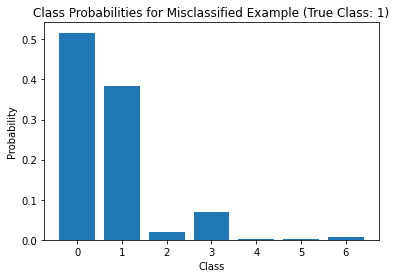

In [30]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
best_model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        outputs = best_model(data.float())
        _, predicted = torch.max(outputs.data, 1)
        incorrect_samples = data[predicted != labels]
        incorrect_predicted = predicted[predicted != labels]
        correct_labels = labels[predicted != labels]
        break  # Find the first batch with misclassifications

# Calculate class probabilities for the misclassified example
softmax_probs = torch.softmax(outputs, dim=1)[0].numpy()
classes = np.arange(num_classes)

# Plot the class probabilities
plt.bar(classes, softmax_probs, tick_label=classes, align='center')
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title(f"Class Probabilities for Misclassified Example (True Class: {correct_labels[0]})")
plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


To explore patterns in the raw data, we'll create three scatter plots:

1. A scatter plot of crime incidents using coordinates with the color indicating the day of the week.
2. Another scatter plot using coordinates with the color indicating the number of persons involved in the incident.
3. We'll sort and display the number of crimes reported by the day of the week to identify the most frequent days.


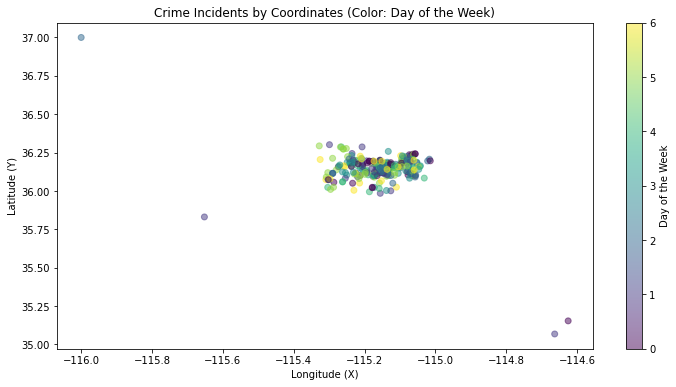

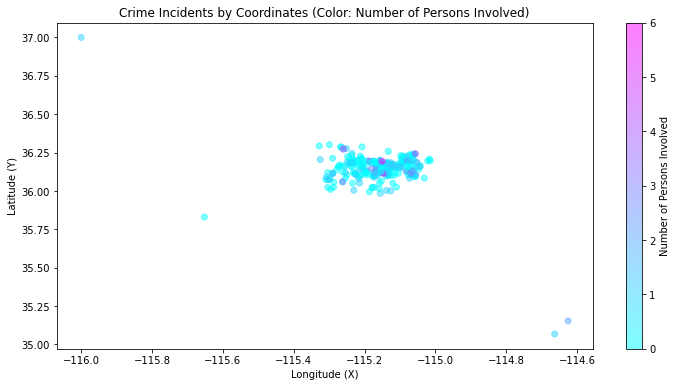

In [31]:
import matplotlib.pyplot as plt

# Scatter plot of crime incidents with color indicating the day of the week
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates (Color: Day of the Week)')
plt.show()

# Scatter plot of crime incidents with color indicating the number of persons involved
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='cool', alpha=0.5)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates (Color: Number of Persons Involved)')
plt.show()


The first scatter plot indicates whether there is a pattern in crime incidents based on the day of the week, and the second scatter plot explores patterns based on the number of persons involved.

Now, let's use numpy to sort and display the number of crimes reported by the day of the week:


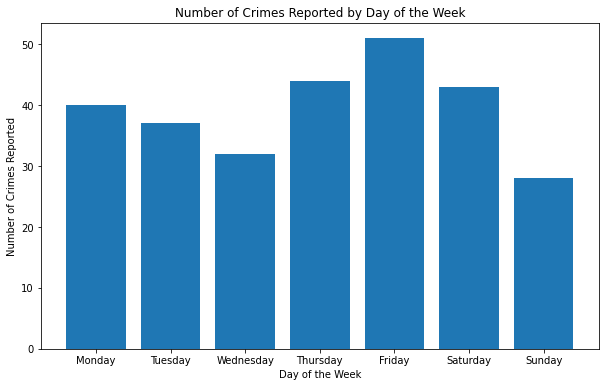

0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: DayOfWeek, dtype: int64

In [32]:
import numpy as np

# Group the data by day of the week and count the number of crimes for each day
day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()

# Days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the number of crimes reported by the day of the week
plt.figure(figsize=(10, 6))
plt.bar(days, day_of_week_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes Reported')
plt.title('Number of Crimes Reported by Day of the Week')
plt.show()

# Display the sorted counts
day_of_week_counts


# References Used 

- Python Documentation for Syntax - https://docs.python.org/3/reference/index.html
- PyTorch Documentation referred - https://pytorch.org/docs/stable/torch.html
- MatPlotLib Documentation - https://matplotlib.org/stable/api/pyplot_summary.html
- Websites like Stack Overflow, Reddit's r/learnprogramming and r/MachineLearning, and the PyTorch discussion forum.